In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd()))
sys.path.append(project_root)

from src.clients.solana.meteora import SolanaMeteoraClient
from src.utils.analyzer import Analyzer
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mpl_dates
import pandas as pd
from datetime import datetime, timedelta
from mplfinance.original_flavor import candlestick_ohlc

client = SolanaMeteoraClient()

Setting API URL: https://dlmm-api.meteora.ag
Setting RPC: https://api.mainnet-beta.solana.com
Creating session...
Session headers set: {'User-Agent': 'python-requests/2.32.3', 'Accept-Encoding': 'gzip, deflate', 'Accept': 'application/json', 'Connection': 'keep-alive', 'Content-type': 'application/json', 'rpc': 'https://api.mainnet-beta.solana.com'}
Initialized MoralisPriceFetcher with API key: eyJh...
Fetching token symbols from CoinGecko...
Mapped 3755 Solana token addresses to symbols


# FETCH NEW LPs DATA

In [15]:
# Fetch and filter pools
pools = client.fetch_liquidity_pools()
min_tvl = 100000
min_volume = 50000
filtered_pairs = client.filter_pairs(pools, min_tvl=min_tvl, min_volume=min_volume)
print(f"Filtered pairs (TVL >= {min_tvl}, Volume >= {min_volume}): {len(filtered_pairs)}")
for pair in filtered_pairs:
    print(pair)

Fetching pools from https://dlmm-api.meteora.ag/pair/all
Status code: 200
Total pools in response: 69819
Sample pool: {'address': '8Pc1rCdM9LEkRKMFZEMaHMN5KvFpAsodyKggHCpT3KHJ', 'name': 'Anon-USDC', 'mint_x': '9McvH6w97oewLmPxqQEoHUAv3u5iYMyQ9AeZZhguYf1T', 'mint_y': 'EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v', 'reserve_x': 'UDMu4bFE2C2Q3AUeErTGCsrmodAEYgU5TH64ShRS21A', 'reserve_y': 'BLNtcBXtP2xkPUAVKcoNYgRqCxuTeYxdzDR4gmz8HUys', 'reserve_x_amount': 20, 'reserve_y_amount': 20, 'bin_step': 125, 'base_fee_percentage': '5', 'max_fee_percentage': '7.6367188', 'protocol_fee_percentage': '5', 'liquidity': '0.00002033123532708081', 'reward_mint_x': '11111111111111111111111111111111', 'reward_mint_y': '11111111111111111111111111111111', 'fees_24h': 0.0, 'today_fees': 0.0, 'trade_volume_24h': 0.0, 'cumulative_trade_volume': '2959.2400', 'cumulative_fee_volume': '158.3200', 'current_price': 16.58209799600042, 'apr': 0.0, 'apy': 0.0, 'farm_apr': 0.0, 'farm_apy': 0.0, 'hide': False, 'is_blacklis

In [16]:
# Filter for native token (SOL) and utility token pairs
native_utility_pairs = client.filter_native_utility_pairs(filtered_pairs)
print(f"Native-Utility pairs found: {len(native_utility_pairs)}")
for pair in native_utility_pairs:
    print(f"Native-Utility pair: {pair.token0_symbol}-{pair.token1_symbol} (TVL: {pair.tvl})")


Native-Utility pairs found: 0


### FIND LARGEST POOL FOR EACH SELECTED TOKEN

In [17]:
# Extract unique tokens and find largest SOL or USDC pool per token
token_to_pool = {}
for token in set(p.token0_address for p in filtered_pairs).union(p.token1_address for p in filtered_pairs):
    # Prefer SOL pool, then USDC if no SOL pool exists
    sol_pool = client.get_largest_pool(token, pools, base_token=client.SOL_ADDRESS)
    usdc_pool = client.get_largest_pool(token, pools, base_token=client.USDC_ADDRESS)
    largest_pool = sol_pool if sol_pool else usdc_pool
    if largest_pool:
        ticker = f"{largest_pool.token0_symbol}"
        base = f"{largest_pool.token1_symbol}"
        token_to_pool[token] = {
            "pair_address": largest_pool.address,
            "ticker": ticker,
            "base": base,
            "tvl": largest_pool.tvl
        }

tokens = set(token_to_pool.keys())
print(f"Tokens to analyze: {len(tokens)}")
print(token_to_pool)


Tokens to analyze: 20
{'A8C3xuqscfmyLrte3VmTqrAq8kgMASius9AFNANwpump': {'pair_address': '5eDWEqd9LuedRwXCaVkghFjyRTT2aMeEr667y65bzmEu', 'ticker': 'FWOG', 'base': 'SOL', 'tvl': 102160.19457367997}, '63LfDmNb3MQ8mw9MtZ2To9bEA2M71kZUUGq5tiJxcqj9': {'pair_address': '44bUbBQxukyZ8rr3B5W8L3Gm8dm1QcL7gERD32zL7vpY', 'ticker': 'GIGA', 'base': 'SOL', 'tvl': 284134.8732066014}, 'bSo13r4TkiE4KumL71LsHTPpL2euBYLFx6h9HP3piy1': {'pair_address': '3q4KmkMmzatUwvBs15Pdn2PR1X6h8GvuoXF5T9cPejqF', 'ticker': 'BSOL', 'base': 'SOL', 'tvl': 35448.05887073135}, 'KMNo3nJsBXfcpJTVhZcXLW7RmTwTt4GVFE7suUBo9sS': {'pair_address': '4UopaeYzxPyHtSYcvb1Cj9U3Z8uUf3yngsrTExqi2JAh', 'ticker': 'KMNO', 'base': 'SOL', 'tvl': 134406.34493822412}, 'jupSoLaHXQiZZTSfEWMTRRgpnyFm8f6sZdosWBjx93v': {'pair_address': 'bNcdL9Hy85c9qb4hRavAUFtJUiyRPh3u96jerFqZQq6', 'ticker': 'JUPSOL', 'base': 'SOL', 'tvl': 210725.98912754143}, '9zNQRsGLjNKwCUU5Gq5LR8beUCPzQMVMqKAi3SSZh54u': {'pair_address': 'HSf69qmDooFF7Wxr2581fgpJNxAjwCeZmx8gf2q3BCAb'

### CHOOSE OUTPUT DIRECTORY

In [19]:
# Set up output folder
output_dir = os.path.join(project_root, "price_data_1")
os.makedirs(output_dir, exist_ok=True)
print(f"Price data will be saved in: {output_dir}")

Price data will be saved in: /Users/nicolaschiavo/Dev/internship/dex_analyzer/price_data_1


### FETCH OLHCV DATA FOR EACH TOKEN VS USD OR SOL

In [ ]:
# Fetch and save price history with 1-hour timeframe
price_bars = []
from_date = (datetime.now() - timedelta(days=7)).strftime("%Y-%m-%d")
to_date = datetime.now().strftime("%Y-%m-%d")

# change base to 'native' to get the prices in SOL, or to 'usd' to have it in dollars
base = "usd"

for token in tokens:
    pool_info = token_to_pool[token]
    pair_address = pool_info["pair_address"]
    ticker = pool_info["ticker"]
    
    pb = client.get_price_bars(pair_address, ticker, from_date, to_date, timeframe="4h",base_currency=base)
    
    if pb is None or pb.data is None:
        print(f"No data for {token}; skipping save.")
        continue

    # Save to pickle file
    if base == "usd":
        pickle_path = os.path.join(output_dir, f"{ticker}-USD.pkl")
    elif base == "native":
        pickle_path = os.path.join(output_dir, f"{ticker}-SOL.pkl")

    pb.data.to_pickle(pickle_path)
    print(f"Saved price data to {pickle_path}")
    
    price_bars.append(pb)

Requesting page 1: https://solana-gateway.moralis.io/token/mainnet/pairs/5eDWEqd9LuedRwXCaVkghFjyRTT2aMeEr667y65bzmEu/ohlcv?timeframe=4h&baseCurrency=usd&fromDate=2025-02-20&toDate=2025-02-27&limit=100
Columns after fetch: ['timestamp', 'open', 'high', 'low', 'close', 'volume']
Fetched 43 price bars for pair 5eDWEqd9LuedRwXCaVkghFjyRTT2aMeEr667y65bzmEu (ticker: FWOG, timeframe: 4h)
Saved price data to /Users/nicolaschiavo/Dev/internship/dex_analyzer/price_data_1/FWOG-USD.pkl
Requesting page 1: https://solana-gateway.moralis.io/token/mainnet/pairs/44bUbBQxukyZ8rr3B5W8L3Gm8dm1QcL7gERD32zL7vpY/ohlcv?timeframe=4h&baseCurrency=usd&fromDate=2025-02-20&toDate=2025-02-27&limit=100
Columns after fetch: ['timestamp', 'open', 'high', 'low', 'close', 'volume']
Fetched 43 price bars for pair 44bUbBQxukyZ8rr3B5W8L3Gm8dm1QcL7gERD32zL7vpY (ticker: GIGA, timeframe: 4h)
Saved price data to /Users/nicolaschiavo/Dev/internship/dex_analyzer/price_data_1/GIGA-USD.pkl
Requesting page 1: https://solana-gatewa


Price bar for first token (GIGA vs usd):
                   timestamp      open      high       low     close  \
38 2025-02-20 16:00:00+00:00  0.025342  0.028027  0.025342  0.027016   
39 2025-02-20 12:00:00+00:00  0.027522  0.028266  0.025640  0.025640   
40 2025-02-20 08:00:00+00:00  0.025476  0.027465  0.025476  0.027465   
41 2025-02-20 04:00:00+00:00  0.025459  0.025688  0.024715  0.024706   
42 2025-02-20 00:00:00+00:00  0.023577  0.026148  0.023577  0.025011   

          volume  
38  60243.097943  
39  59007.191470  
40  21222.557705  
41   2672.279461  
42  30440.546681  


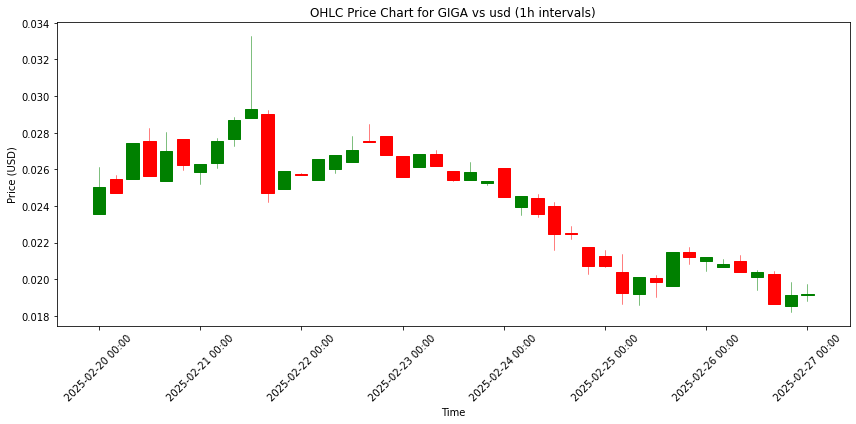

In [33]:
# Print and plot first price bar
if price_bars:
    first_token = price_bars[1]
    print(f"\nPrice bar for first token ({first_token.token_symbol} vs {first_token.base_token}):")
    print(first_token.data.tail())

    plot_data = first_token.data[["timestamp", "open", "high", "low", "close"]].copy()
    plot_data["timestamp"] = pd.to_datetime(plot_data["timestamp"])
    plot_data["timestamp"] = plot_data["timestamp"].map(pd.Timestamp.to_pydatetime).map(mpl_dates.date2num)

    fig, ax = plt.subplots(figsize=(12, 6))
    candlestick_ohlc(ax, plot_data.values, width=0.12, colorup='g', colordown='r')
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d %H:%M"))
    plt.title(f"OHLC Price Chart for {first_token.token_symbol} vs usd (1h intervals)")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No price bars fetched")

# USE ALREADY FETCHED PRICE DATA

In [4]:
import sys
import os
import pandas as pd
import glob

project_root = os.path.abspath(os.path.join(os.getcwd()))
sys.path.append(project_root)

from src.models.price_bar import PriceBar
from src.utils.analyzer import Analyzer

# Directory containing pickle files
output_dir = os.path.join(project_root, "price_data_1")
print(f"Reading pickle files from: {output_dir}")

# Fetch all .pkl files
pickle_files = glob.glob(os.path.join(output_dir, "*.pkl"))
print(f"Found {len(pickle_files)} pickle files: {[os.path.basename(f) for f in pickle_files]}")

Reading pickle files from: /Users/nicolaschiavo/Dev/internship/dex_analyzer/price_data_1
Found 25 pickle files: ['SOL-USD.pkl', 'GRPH-USD.pkl', 'MELANIA-USD.pkl', 'GIGA-SOL.pkl', 'JUPSOL-USD.pkl', 'ASKJ-USD.pkl', 'JITOSOL-USD.pkl', 'KMNO-SOL.pkl', 'ARC-USD.pkl', 'JUPSOL-SOL.pkl', 'GIGA-USD.pkl', 'KMNO-USD.pkl', 'BSOL-USD.pkl', 'FWOG-SOL.pkl', 'LISTEN-USD.pkl', 'BONK-USD.pkl', 'JUP-USD.pkl', 'WBTC-USD.pkl', 'FWOG-USD.pkl', 'INF-USD.pkl', 'BSOL-SOL.pkl', 'TRUMP-USD.pkl', 'ANON-USD.pkl', 'CBBTC-USD.pkl', 'JLP-USD.pkl']


## CALCULATE CORRELATION MATRIX

In [5]:
import os
from src.utils.analyzer import Analyzer

# Define the directory containing your pickle files
pickle_dir = os.path.join(project_root, "price_data_1")

# Collect a list of all .pkl file paths
pickle_files = [
    os.path.join(pickle_dir, fname)
    for fname in os.listdir(pickle_dir)
    if fname.endswith(".pkl")
]

# Compute the correlation matrix directly from the pickle files.
corr_matrix = Analyzer.compute_correlation_matrix_from_pickle(pickle_files)

print("Correlation Matrix:")
display(corr_matrix)

Correlation matrix based on 34 overlapping timestamps
Correlation Matrix:


,SOL,GRPH,MELANIA,GIGA,JUPSOL,ASKJ,JITOSOL,KMNO,ARC,JUPSOL,...,BONK,JUP,WBTC,FWOG,INF,BSOL,TRUMP,ANON,CBBTC,JLP
SOL,1.000000,-0.057147,0.095116,0.309007,0.205467,0.352009,0.199126,0.046240,0.439730,0.205467,...,0.275578,0.521406,0.007841,1.000000,0.202629,0.204266,0.115053,0.293861,0.022332,0.183951
GRPH,-0.057147,1.000000,0.785084,0.833505,0.882023,0.686629,0.880227,0.900032,0.336306,0.882023,...,0.862323,0.708969,0.819434,-0.057147,0.881928,0.876579,0.920973,0.683543,0.836095,0.868135
MELANIA,0.095116,0.785084,1.000000,0.917705,0.945004,0.572317,0.945162,0.955928,0.293512,0.945004,...,0.936744,0.847884,0.963740,0.095116,0.945589,0.945296,0.942555,0.328246,0.968078,0.956162
GIGA,0.309007,0.833505,0.917705,1.000000,0.969630,0.735396,0.969954,0.943180,0.448987,0.969630,...,0.967534,0.915545,0.919158,0.309007,0.970878,0.970650,0.940092,0.568891,0.924475,0.970739
JUPSOL,0.205467,0.882023,0.945004,0.969630,1.000000,0.715299,0.999170,0.965584,0.411792,1.000000,...,0.982931,0.909184,0.937727,0.205467,0.999419,0.998075,0.981614,0.557780,0.947721,0.996229
ASKJ,0.352009,0.686629,0.572317,0.735396,0.715299,1.000000,0.708027,0.659822,0.872778,0.715299,...,0.774801,0.748001,0.545212,0.352009,0.718318,0.706034,0.692353,0.654139,0.564005,0.693378
JITOSOL,0.199126,0.880227,0.945162,0.969954,0.999170,0.708027,1.000000,0.964913,0.404691,0.999170,...,0.980391,0.903708,0.939561,0.199126,0.999406,0.998618,0.981945,0.553499,0.948866,0.996967
KMNO,0.046240,0.900032,0.955928,0.943180,0.965584,0.659822,0.964913,1.000000,0.337219,0.965584,...,0.950717,0.834437,0.971932,0.046240,0.965087,0.962557,0.965261,0.512907,0.975738,0.970775
ARC,0.439730,0.336306,0.293512,0.448987,0.411792,0.872778,0.404691,0.337219,1.000000,0.411792,...,0.513625,0.560835,0.217047,0.439730,0.416178,0.400557,0.379414,0.410811,0.235724,0.392088
JUPSOL,0.205467,0.882023,0.945004,0.969630,1.000000,0.715299,0.999170,0.965584,0.411792,1.000000,...,0.982931,0.909184,0.937727,0.205467,0.999419,0.998075,0.981614,0.557780,0.947721,0.996229


## CALCULATE BETA TO SOL

In [6]:
import os
from src.utils.analyzer import Analyzer

# Define the directory containing your pickle files
pickle_dir = os.path.join(project_root, "price_data_1")

# Define the SOL pickle file path
sol_pickle = os.path.join(pickle_dir, "SOL-USD.pkl")

# Collect a list of all other token pickle file paths (exclude SOL)
token_pickle_files = [
    os.path.join(pickle_dir, fname)
    for fname in os.listdir(pickle_dir)
    if fname.endswith(".pkl") # and not fname.startswith("SOL")
]

# Compute beta for each token with respect to SOL
beta_results = Analyzer.compute_beta_with_sol(sol_pickle, token_pickle_files)

print("Beta values (relative to SOL):")
for token, beta in beta_results.items():
    print(f"{token}: {beta}")

Beta values (relative to SOL):
SOL: 1.0000000000000002
GRPH: 0.22992007757818156
MELANIA: 0.12552877346010594
GIGA: 0.3505975394014772
JUPSOL: 0.12278708131887268
ASKJ: 0.23808308790931262
JITOSOL: 0.13277185023132876
KMNO: 0.15306687287493037
ARC: 0.15332572422347088
BSOL: 0.11224100504423438
FWOG: 1.0000000000000002
LISTEN: 0.23375280042458868
BONK: 0.14293422083498455
JUP: 0.12663585689874998
WBTC: 0.06042049322593491
INF: 0.1311069671260192
TRUMP: 0.14800236886644005
ANON: 0.26399243040248394
CBBTC: 0.04658040634441562
JLP: 0.06345892802724291
